In [19]:
from scipy.sparse.linalg import cg
import scipy.io
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import time
from scipy.sparse.linalg import spilu
from scipy.sparse import identity
from scipy.sparse.linalg import gmres
from scipy.sparse import csr_matrix
import pyamg
import scipy.sparse as sp
from pyamg.relaxation.relaxation import jacobi
from pyamg.aggregation import jacobi_prolongation_smoother
from pyamg.multilevel import MultilevelSolver
from pyamg.relaxation.smoothing import change_smoothers

np.random.seed(123) 

def scipy_to_csr(A_scipy):
    """将 SciPy 稀疏矩阵转换为 CSR 矩阵"""
    return A_scipy.tocsr()

# 读取 .mat 文件
data = scipy.io.loadmat('A10w.mat')
A = scipy_to_csr(data['A'])

data = scipy.io.loadmat('b.mat')
b = data['b']

def amg_gmres(A, b, P):
    start_time = time.time()
    m = 20
    n1 = A.shape[0]
    V = np.zeros((n1, m + 1))
    H = np.zeros((m + 1, m))
    b0 = np.zeros(m + 1)
    x = np.zeros_like(b)
    N = 200
    errors = np.zeros(N)

    R = P.T
    levels = []
    levels.append(MultilevelSolver.Level())
    levels.append(MultilevelSolver.Level())
    levels[0].A = A
    levels[0].P = P
    levels[0].R = R
    levels[1].A = R @ A @ P                      # coarse-level matrix
    m1 = MultilevelSolver(levels, coarse_solver='splu')
    #m1 = pyamg.aggregation.smoothed_aggregation_solver(A,max_coarse= 10, coarse_solver='splu')
    smoothers = ('jacobi', {'iterations' : 3,'omega': 0.66})
    change_smoothers(m1, presmoother=smoothers, postsmoother=smoothers)

    precond = m1.aspreconditioner(cycle='V')
    #Time = time.time() - start_time
    

    for kk in range(N):
        #print(b.shape,x.shape)
        r0 = b - A @ x
        r0 = precond(r0)  # 使用 AMG 预条件器求解
        beta = np.linalg.norm(r0)
        b0[0] = beta
        v1 = r0 / beta
        V[:, 0] = v1.reshape(-1)

        for j in range(m):
            w = A @ V[:, j]
            w = precond(w)  # 预条件处理

            for i in range(j + 1):
                h = np.dot(w, V[:, i])
                #print(h,h.shape,V[:,i].shape)
                w = w - h * V[:, i]
                H[i, j] = h

            H[j + 1, j] = np.linalg.norm(w)
            V[:, j + 1] = w / H[j + 1, j]

        y, _, _, _ = np.linalg.lstsq(H[:m, :m], b0[:m], rcond=None)
        #print(x.shape,V[:,:m].shape,y.shape)
        x = x + V[:, :m]@y.reshape(m,1)
        errors[kk] = np.linalg.norm(A@x-b)/np.linalg.norm(b)
        #print(kk+1,errors[kk])
        if errors[kk]<1e-7:
            #print(f"迭代 {kk+1}，残差: {errors[kk]:.2e}")
            break
        if kk>198:
            print(f"迭代 {kk+1}，残差: {errors[kk]:.2e}")
            break
    Time = time.time() - start_time
    return x, errors[kk], Time,kk+1




In [21]:
from scipy.sparse import csc_matrix
mat_data = scipy.io.loadmat('u_GRF10w.mat')

# 提取 cell 数组
u = mat_data['u_GRF']  # 这是一个 numpy 对象数组
#u = [csc_matrix(data_b[0, i]) for i in range(data_b.shape[1])]
data = scipy.io.loadmat('PP10w_A16.mat')
#P = sp.csr_matrix(data['P'])
P = scipy_to_csr(data['PP'])
density = P.nnz / (P.shape[0] * P.shape[1])
print(f"稠密度: {density:.4f}")
R = P.T


T=0
K=0
rl2=0
l00=0
l2=0
N=1
iters=np.zeros((100,1))
for i in range(N):
    ui=u[0,i]
    #print(ui.shape)
    bi=A@ui
    #bi=bi.toarray()
    sol_tb, errors, Time,k=amg_gmres(A, bi, P)
    T=T+Time
    K=K+k
    iters[i,0]=k
    #print(k)
    rl2=rl2+errors
    N_xy=A.shape[0]
    max_abs_error = np.max(np.abs(sol_tb.reshape(N_xy,) - ui.reshape(N_xy,)))
    el2=np.linalg.norm(np.abs(sol_tb.reshape(N_xy,) - ui.reshape(N_xy,)))/np.linalg.norm(ui.reshape(N_xy,))
    l00=l00+max_abs_error
    l2=l2+el2
T=T/N
K=K/N
rl2=rl2/N
l00=l00/N
l2=l2/N
print(f"{K} {rl2:.2e} {l2:.2e} {l00:.2e} {T:.2f}")
data = {'iters': iters}
#scipy.io.savemat('iters.mat', data)

稠密度: 0.0625
23.0 6.97e-08 1.30e-06 2.96e-06 8.29


max_abs_error = 1.97e-04, l2 = 6.25e-03


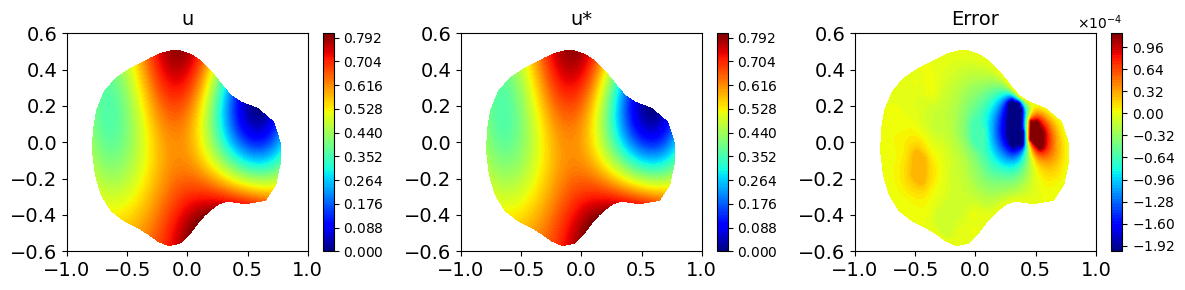

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.io import loadmat
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import FuncFormatter
u_ex=ui

data = loadmat('mesh1w.mat')
# Extract node coordinates, boundary edges, and triangular elements
p = data['p']  # N × 2 matrix of node coordinates
e = np.array(data['e'], dtype=float)  # L × 2 matrix of boundary edges (converted to float)
t = np.array(data['t'], dtype=float)  # M × 3 matrix of triangular elements (converted to float)
triang = tri.Triangulation(p[:,0], p[:,1],t-1)

N_xy=p.shape[0]
max_abs_error = np.max(np.abs(sol_tb.reshape(N_xy,) - u_ex.reshape(N_xy,)))
l2=np.linalg.norm(np.abs(sol_tb.reshape(N_xy,) - u_ex.reshape(N_xy,)))
print(f"max_abs_error = {max_abs_error:.2e}, l2 = {l2:.2e}")

def sci_formatter(x, pos):
    return f'{x:.2e}'  # 保留两位有效数字，科学计数法显示


titles = ['u', 'u*', 'Error']
data_list = [
    u_ex.reshape(N_xy,),
    sol_tb.reshape(N_xy,),                 # u*
    sol_tb.reshape(N_xy,) - u_ex.reshape(N_xy,)  # error
]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 创建1行3列子图，整体宽度12英寸，高度3英寸

for i, ax in enumerate(axes):
    contour = ax.tricontourf(triang, data_list[i], levels=100, cmap='jet')
    #fig.colorbar(contour, ax=ax)  # 给每个子图添加 colorbar

    cbar = fig.colorbar(contour, ax=ax)  # 给每个子图添加 colorbar
    cbar.ax.ticklabel_format(style='sci', scilimits=(-2, 2), useMathText=True)
    ax.set_xticks(ax.get_xticks())  # 显式设置刻度以便字体生效
    ax.set_yticks(ax.get_yticks())
    ax.tick_params(labelsize=14)
    #ax.set_aspect('equal')  # 保持坐标比例一致
    ax.set_title(titles[i], fontsize=14)  # 可选：加上子图标题

plt.tight_layout()
plt.savefig('GRF.eps', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#10w全区域随机
#AMG
#GRF

#10w
#AMG
#GRF
#65.2 3.13e-08 5.61e-04 1.17e-03 34.88
#High
#43.0 4.49e-08 4.88e-04 1.99e-03 23.23
#Low
#71.4 4.28e-08 1.93e-04 6.79e-04 48.32

#RNB
#GRF
#A 37.0 8.55e-08 9.07e-04 2.68e-03 18.98
#B 15.6 5.95e-08 7.12e-05 1.39e-04 12.13
#High
#A 123.0 8.43e-08 1.16e-03 8.07e-03 58.59
#B 17.2 6.07e-08 1.14e-04 4.75e-04 13.22
#Low
#A 72.2 8.64e-08 4.66e-04 3.85e-03 38.39
#B 14.8 5.08e-08 2.23e-05 9.74e-05 12.21

#TB
#GRF
#A 26.0 6.38e-08 8.94e-04 2.48e-03 12.90
#B 53.2 6.23e-08 2.60e-04 4.92e-04 35.78
#High
#A 97.8 7.59e-08 1.42e-03 9.02e-03 60.71
#B 48.2 6.62e-08 4.61e-04 2.06e-03 44.42
#Low
#A 32.0 6.70e-08 3.72e-04 2.91e-03 21.33
#B 38.4 5.76e-08 9.12e-05 5.76e-04 36.10


In [ ]:
#16*16
#deeponet
#GRF
#A 78.2 7.02e-08 2.49e-04 5.90e-04 3.59
#B 14.6 2.13e-08 7.35e-05 1.46e-04 0.85
#High
#A 85.8 7.76e-08 2.11e-03 7.73e-03 5.05
#B 12.4 6.19e-08 7.13e-04 2.05e-03 1.07
#Low
#A 58.0 8.30e-08 6.02e-04 3.51e-03 2.70
#B 17.0 5.10e-08 2.02e-04 1.13e-03 0.97

#ini
#GRF
#A 47.0 7.09e-08 2.69e-04 6.62e-04 2.21
#B 13.2 5.69e-08 1.23e-04 2.19e-04 0.76
#High
#A 30.6 7.17e-08 1.64e-03 6.23e-03 2.01
#B 12.8 4.59e-08 3.76e-04 1.14e-03 1.10
#Low
#A 33.0 7.02e-08 3.98e-04 2.93e-03 1.54
#B 13.8 6.13e-08 1.01e-04 5.42e-04 0.79
